In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Species

In [2]:
df_species = pd.read_parquet('../processed_data/species_coverage.parquet')

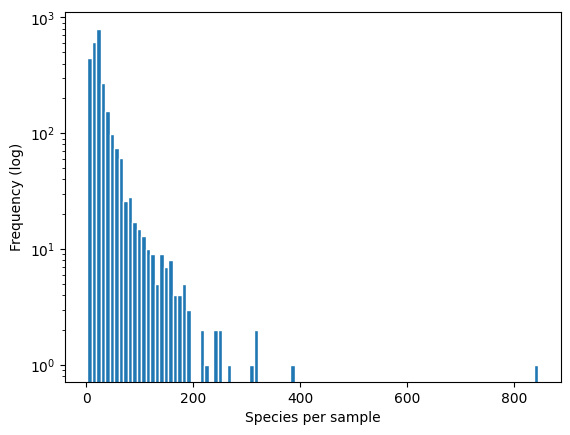

In [3]:
# Species per Sample
count_species_sample = (df_species > 0).sum(1).sort_values(ascending=False)
plt.hist(count_species_sample.values, edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Species per sample')
plt.yscale('log')
plt.show()

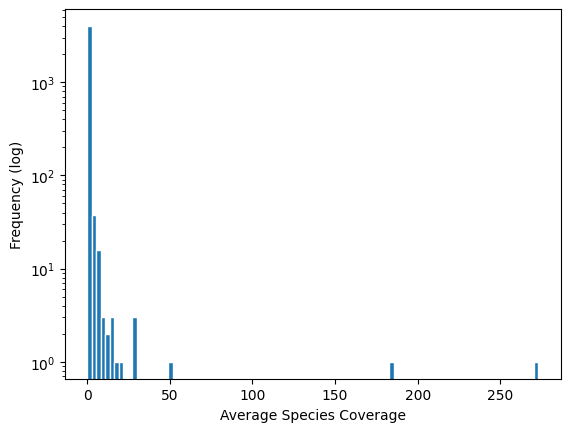

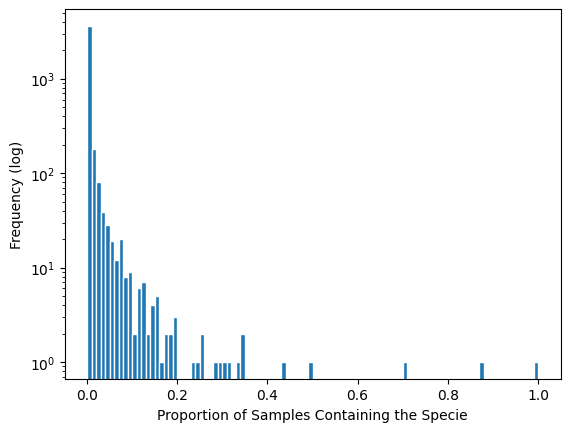

In [4]:
# Average Species Coverage
sum_species_coverage = df_species.sum(0).sort_values(ascending=False)
plt.hist(sum_species_coverage.values/df_species.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Average Species Coverage')
plt.yscale('log')
plt.show()

# Average Species Count
count_species = (df_species > 0).sum(0).sort_values(ascending=False)
plt.hist(count_species.values / df_species.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Proportion of Samples Containing the Specie')
plt.yscale('log')
plt.show()

In [5]:
count_threshold = 100

print(f'# Species that appear in less than {count_threshold} samples: {int((count_species < count_threshold).sum())}')

# Species that appear in less than 100 samples: 3916


# Genes

In [6]:
df_genes = pd.read_parquet('../processed_data/gene_coverage.parquet')
df_genes = df_genes.set_index("Sample")

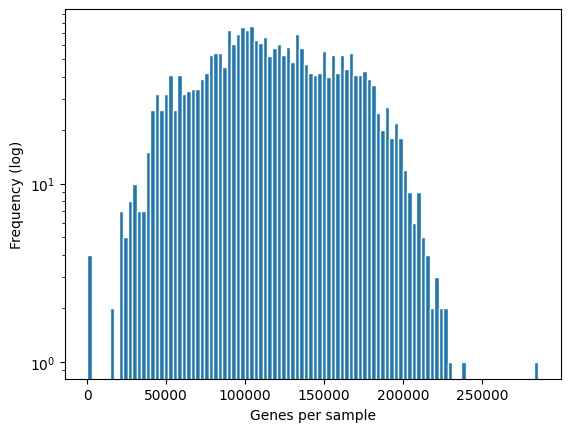

In [7]:
# Genes per Sample
count_genes_sample = (df_genes > 0).sum(1).sort_values(ascending=False)
plt.hist(count_genes_sample.values, edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Genes per sample')
plt.yscale('log')
plt.show()

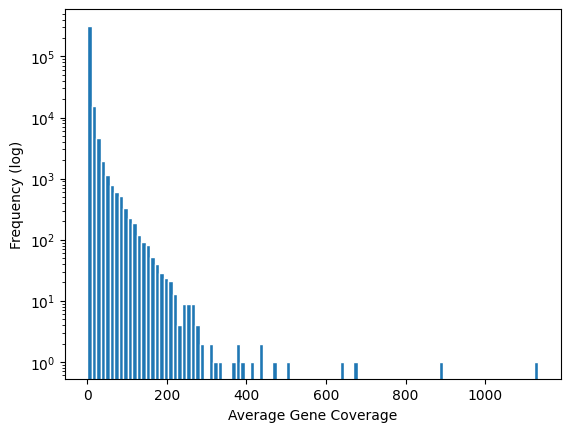

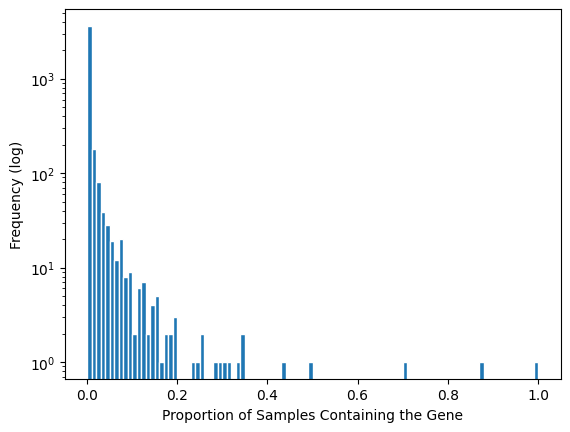

In [8]:
# Average Gene Coverage
sum_species_coverage = df_genes.sum(0).sort_values(ascending=False)
plt.hist(sum_species_coverage.values/df_genes.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Average Gene Coverage')
plt.yscale('log')
plt.show()

# Average Gene Count
count_genes = (df_genes > 0).sum(0).sort_values(ascending=False)
plt.hist(count_species.values / df_genes.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Proportion of Samples Containing the Gene')
plt.yscale('log')
plt.show()

In [9]:
count_threshold = 100

print(f'# Genes that appear in less than {count_threshold} samples: {int((count_genes < count_threshold).sum())}')

# Genes that appear in less than 100 samples: 64639


# Useless Data

In [10]:
print(f'{(count_genes==0).sum()} genes never show up')
print(f'{(count_species==0).sum()} species never show up')
print('\n')
print(f'{(df_species.sum(1)==0).sum()} samples containt no species present')
print(f'{(df_genes.sum(1)==0).sum()} samples containt no species present')
print('\n')
print(f'{(count_genes==df_genes.shape[0]).sum()} genes always show up')
print(f'{(count_species==df_species.shape[0]).sum()} species always show up') # bifidus infantis should show up on all samples (and it does!)

6328 genes never show up
0 species never show up


0 samples containt no species present
0 samples containt no species present


0 genes always show up
1 species always show up


# Sparsity

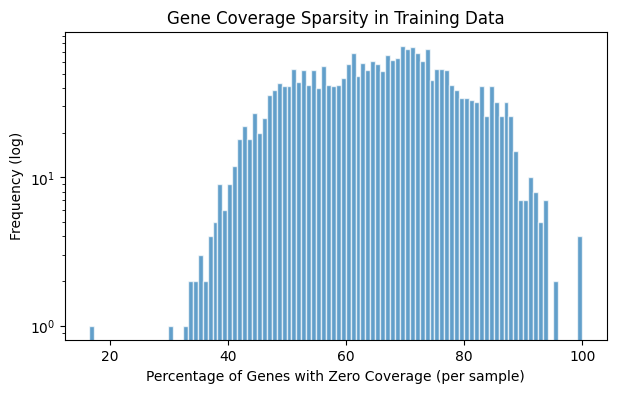

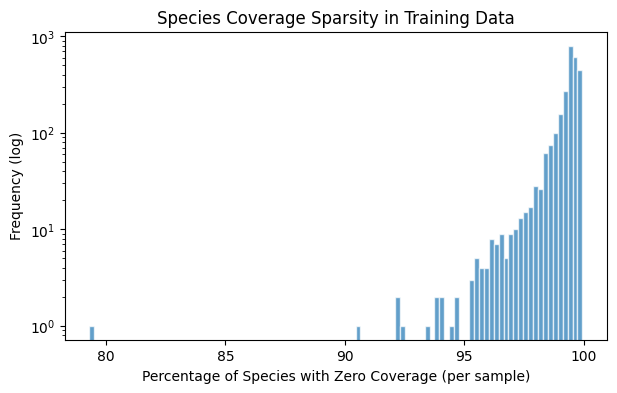

In [11]:
# Gene Sparsity per Sample
gene_sparsity = (df_genes == 0).sum(axis=1) / df_genes.shape[1] * 100

plt.figure(figsize=(7, 4))
plt.hist(gene_sparsity.values, bins=100, edgecolor='white', alpha=0.7)
plt.xlabel("Percentage of Genes with Zero Coverage (per sample)")
plt.ylabel("Frequency (log)")
plt.yscale("log")  # Log scale for better visibility
plt.title("Gene Coverage Sparsity in Training Data")
plt.show()

# Species Sparsity per Sample
species_sparsity = (df_species == 0).sum(axis=1) / df_species.shape[1] * 100  # Percentage of zero species per sample

plt.figure(figsize=(7, 4))
plt.hist(species_sparsity.values, bins=100, edgecolor='white', alpha=0.7)
plt.xlabel("Percentage of Species with Zero Coverage (per sample)")
plt.ylabel("Frequency (log)")
plt.yscale("log")  # Log scale for better visibility
plt.title("Species Coverage Sparsity in Training Data")
plt.show()

## Core Genes

$$
M_{ij} = \frac{\sum_k S_{ki} G_{kj}}{\min(N_i, N_j)}
$$

where:

$$
S \in \{0,1\}^{n_{\text{samples}} \times n_{\text{species}_f}},
$$
$$
G \in \{0,1\}^{n_{\text{samples}} \times n_{\text{genes}_f}}
$$

$$
N_i = \sum_k S_{ki}, \quad N_j = \sum_k G_{kj}
$$


In [12]:
# We'll use a co-occurrence matrix to determine the core genes. 
# For it to be manageable we must remove non statistically significant species and genes!

###############################################################################
# 0) Parameters
###############################################################################
threshold = 200  # minimum number of samples in which a gene/species must appear

###############################################################################
# 1) Match sample indices
###############################################################################
common_samples = np.intersect1d(df_genes.index.values, df_species.index.values)
df_genes_matched = df_genes.loc[common_samples]
df_species_matched = df_species.loc[common_samples]

###############################################################################
# 2) Apply the per-column presence filter (≥ threshold)
#    - We want to keep only those genes/species that appear in at least
#      'threshold' samples.
###############################################################################

# Convert to NumPy arrays
genes_array = df_genes_matched.to_numpy()     # shape (n_samples, n_genes)
species_array = df_species_matched.to_numpy() # shape (n_samples, n_species)

# Boolean arrays where True = present (> 0), False = absent (== 0)
genes_presence = (genes_array > 0)
species_presence = (species_array > 0)

# Count how many samples have each gene (column) present
gene_nonzero_counts = np.sum(genes_presence, axis=0)  # shape (n_genes,)
# Build mask for columns that appear in >= threshold samples
gene_mask = gene_nonzero_counts >= threshold

# Count how many samples have each species (column) present
species_nonzero_counts = np.sum(species_presence, axis=0)  # shape (n_species,)
# Build mask for columns that appear in >= threshold samples
species_mask = species_nonzero_counts >= threshold

# Filter arrays to keep only those columns
genes_filtered = genes_array[:, gene_mask]       # shape (n_samples, n_genes_f)
species_filtered = species_array[:, species_mask] # shape (n_samples, n_species_f)

# Also build the new presence arrays so we can do co-occurrence
genes_presence_f = genes_presence[:, gene_mask]       # shape (n_samples, n_genes_f)
species_presence_f = species_presence[:, species_mask] # shape (n_samples, n_species_f)

###############################################################################
# 3) Compute the co-occurrence matrix
#    We want a matrix of shape (n_species_f, n_genes_f) with entries:
#       #samples where species_i & gene_j both present
#       -------------------------------------------------
#       max(#samples species_i present, #samples gene_j present)
###############################################################################

# Count co-occurrences using matrix multiplication:
#   presence_species_f: shape (n_samples, n_species_f) --> but we need (n_samples, n_species_f) * (n_samples, n_genes_f)?
#   Actually we want (n_species_f, n_samples) @ (n_samples, n_genes_f) => (n_species_f, n_genes_f)
#   So we transpose species_presence_f to shape (n_species_f, n_samples).

# However, np.dot(...) needs numeric (int/float). We can cast bool->int.
species_int = species_presence_f.astype(int).T   # shape (n_species_f, n_samples)
genes_int = genes_presence_f.astype(int)         # shape (n_samples, n_genes_f)

# co_occurrence_counts[i, j] = sum over samples of (species_i_present * gene_j_present)
co_occurrence_counts = np.dot(species_int, genes_int)  # shape (n_species_f, n_genes_f)

# Next, we need the denominators:
#   denom(i, j) = max(#samples species_i present, #samples gene_j present)
# We already have species_nonzero_counts and gene_nonzero_counts, but let's
# get them for the *filtered* sets:
species_pres_counts_f = np.sum(species_presence_f, axis=0)  # shape (n_species_f,)
gene_pres_counts_f = np.sum(genes_presence_f, axis=0)       # shape (n_genes_f,)

# For each (i, j), denominator = max(species_pres_counts_f[i], gene_pres_counts_f[j]).
# We can do that in a fully vectorized way with np.maximum.outer:
denominator_matrix = np.minimum.outer(species_pres_counts_f, gene_pres_counts_f)  
# shape (n_species_f, n_genes_f)

# Finally, compute the ratio. Convert to float to avoid integer division:
co_occurrence_matrix = co_occurrence_counts / denominator_matrix

###############################################################################
# 4) Wrap up results
#    co_occurrence_matrix has shape (n_species_f, n_genes_f).
#    Optionally, you can build a DataFrame with the filtered names:
###############################################################################
filtered_species_names = df_species_matched.columns[species_mask]
filtered_gene_names = df_genes_matched.columns[gene_mask]

df_co_occurrence = pd.DataFrame(
    co_occurrence_matrix,
    index=filtered_species_names,
    columns=filtered_gene_names
)

print("Co-occurrence matrix shape:", df_co_occurrence.shape)

Co-occurrence matrix shape: (78, 255201)


In [13]:
df_co_occurrence.T

,Bifidobacterium longum,Bifidobacterium infantis,Bifidobacterium breve,Bifidobacterium bifidum,Bacteroides fragilis,Phocaeicola vulgatus,Parabacteroides distasonis,Faecalibacterium longum,Faecalibacterium sp900758465,Flavonifractor plautii,...,Faecalibacterium duncaniae,Lactobacillus sp944327175,Lactobacillus delbrueckii,Streptococcus mutans,Blautia coccoides,Pseudomonas_E putida,Megasphaera elsdenii,Agathobacter faecis,Bifidobacterium dentium,Anaeroglobus micronuciformis
MGYG000040295_1_1076,0.957884,1.0,0.626836,0.630513,0.513189,0.414729,0.228442,0.430052,0.511848,0.293269,...,0.096059,0.011494,0.018587,0.014981,0.059561,0.000000,0.099502,0.462882,0.375000,0.385366
MGYG000235258_187_1,0.990361,1.0,0.321687,0.251807,0.352518,0.418605,0.611195,0.383420,0.336493,0.549398,...,0.773399,0.915709,0.903346,0.906367,0.827586,0.920949,0.721393,0.493450,0.375000,0.317073
MGYG000287854_166_1,0.961342,1.0,0.688412,0.746126,0.719424,0.651163,0.402421,0.805699,0.786730,0.465144,...,0.322660,0.019157,0.040892,0.037453,0.128527,0.000000,0.139303,0.882096,0.516667,0.497561
MGYG000081795_71_1,0.983412,1.0,0.386256,0.286730,0.223022,0.310427,0.270142,0.256477,0.199052,0.338863,...,0.145320,0.011494,0.014870,0.022472,0.068966,0.000000,0.019900,0.353712,0.262500,0.170732
MGYG000251915_8_1,0.959677,1.0,0.608871,0.508065,0.472422,0.472868,0.307110,0.577720,0.592417,0.360215,...,0.211823,0.015326,0.033457,0.029963,0.075235,0.000000,0.119403,0.580786,0.591667,0.492683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGYG000032708_99_5,0.967593,1.0,0.350926,0.339690,0.405276,0.451550,0.682300,0.458549,0.478673,0.591346,...,0.830049,0.980843,0.973978,0.977528,0.887147,1.000000,0.860697,0.497817,0.458333,0.351220
MGYG000174374_194_5,0.983087,1.0,0.533827,0.474374,0.503597,0.459302,0.285930,0.378238,0.388626,0.322115,...,0.160099,0.042146,0.048327,0.059925,0.119122,0.031621,0.084577,0.423581,0.458333,0.404878
MGYG000063533_28_7,0.967611,1.0,0.619433,0.473684,0.419664,0.403101,0.220877,0.487047,0.545024,0.283401,...,0.103448,0.015326,0.014870,0.011236,0.043887,0.000000,0.069652,0.353712,0.250000,0.321951
MGYG000178890_63_8,0.894630,1.0,0.679828,0.718713,0.623501,0.687984,0.429652,0.715026,0.696682,0.459135,...,0.278325,0.076628,0.085502,0.082397,0.169279,0.051383,0.159204,0.689956,0.608333,0.590244


In [14]:
# Sanity check. Bifidobacterium infantis should have all genes always
df_co_occurrence.T['Bifidobacterium infantis'].sum() == df_co_occurrence.shape[1]

np.True_

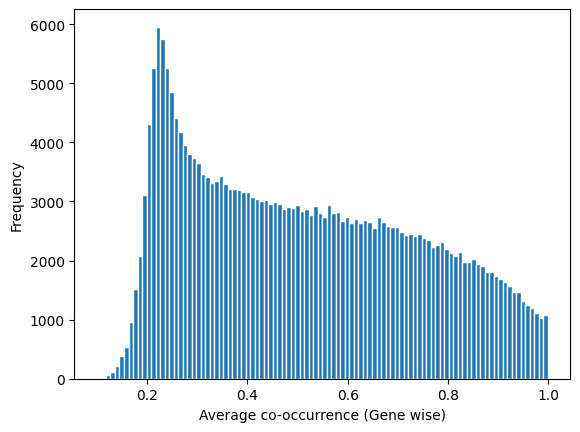

In [15]:
# Co-occurrence sum per gene
sum_co_occ_genes = df_co_occurrence.T.sum(1)/df_co_occurrence.shape[0]
plt.hist(sum_co_occ_genes.values, edgecolor='white', bins=100)
plt.ylabel('Frequency')
plt.xlabel('Average co-occurrence (Gene wise)')
#plt.yscale('log')
plt.show()

# Samples

## Cosine Similarity

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
print(f'{int(0.5*df_species.shape[0]**2) - df_species.shape[0]} Operations')

df_species = df_species.loc[df_genes.index]
# (df_species.index == df_genes.index).sum() == df_species.shape[0] # sanity check

3615360 Operations


In [18]:
# species similarity
print('Generating species similarity matrix...')
species_cosine_sim_matrix = pd.DataFrame(
    cosine_similarity(df_species),
    index=df_species.index,
    columns=df_species.index
)

# genes similarity
print('Generating genes similarity matrix...')
genes_cosine_sim_matrix = pd.DataFrame(
    cosine_similarity(df_genes),
    index=df_genes.index,
    columns=df_genes.index
)

Generating species similarity matrix...
Generating genes similarity matrix...


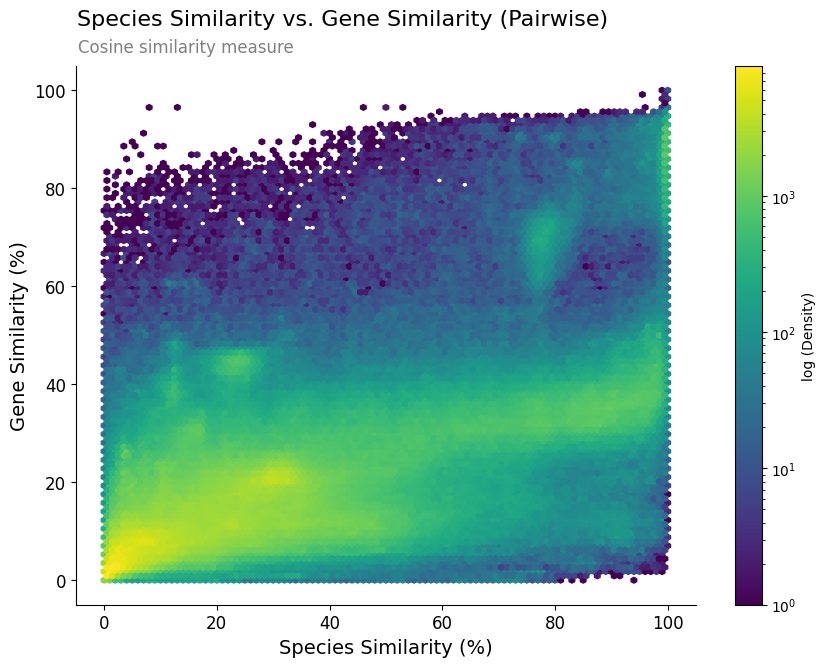

In [19]:
# Extract upper triangle values (excluding diagonal)
species_vals = species_cosine_sim_matrix.where(np.triu(np.ones(species_cosine_sim_matrix.shape), k=1).astype(bool)).stack()
genes_vals = genes_cosine_sim_matrix.where(np.triu(np.ones(genes_cosine_sim_matrix.shape), k=1).astype(bool)).stack()

plt.figure(figsize=(10, 7))
hb = plt.hexbin(
    species_vals * 100, genes_vals * 100, gridsize=100, cmap='viridis', bins='log'
)

cb = plt.colorbar(label='log (Density)')

plt.xlabel('Species Similarity (%)', fontsize=14)
plt.ylabel('Gene Similarity (%)', fontsize=14)
plt.title('Species Similarity vs. Gene Similarity (Pairwise)', fontsize=16, x=0.43, y=1.06)
plt.suptitle('Cosine similarity measure', fontsize=12, color='gray', x=0.235, y=0.92)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.show()